# Comparison between standard PH and Ellipse Cloud PH

This notebook showcases the numerical experiments to compare the performance between standard persistent homology and anisotropic persistent homology using Ellipse Cloud. The output figures are those that the author presented in ATMCS2025 (Montana).

In [1]:
import numpy
import matplotlib
import matplotlib.pyplot as plt
import ellphi

# from tqdm import tqdm
from itertools import combinations
import homcloud.interface as hc
from scipy.spatial.distance import pdist, squareform

In [2]:
%matplotlib inline

In [3]:
rng = numpy.random.default_rng(seed=7777) # 20250224
# rng = numpy.random.default_rng(seed=777)
# rng = numpy.random.default_rng(seed=77)

alpha = 0.5 # 透過アルファ値
near = 25 # k-nbd
# max_iter = 3000
take = 10
experiments = ('standard', 'anisotropic', 'preprocessed')

In [4]:
fig_config = dict(figsize=(24, 12), dpi=150)
scatter_config = dict(s=6, color='black', marker='o')
ellipse_config = dict(lw=2, alpha=alpha)
pd_hist_config = dict(colorbar=dict(type="linear", colormap='magma_r'))
imshow_config = dict(origin='lower', cmap='viridis', norm='log', interpolation='none')
rings_config = dict(
    radius=0.6, # 基本ノイズ円の半径
    aspect_ratio=0.4, # 基本円のアスペクト比
    num_points=100, # 基本円の点数
    eps=0.19, # ノイズ一様分布 [-eps, eps]
    shape_clusters=(2, 3) # 基本円をこの列・行ならべる
)
bins = 35
output_dir = './output_figures'
pdgm_tmpfile = '/tmp/rips.pdgm'

cmap = matplotlib.colormaps['tab10']

In [5]:
!mkdir -p {output_dir}

In [6]:
def show_savefig(fig, figname, show=False, output_dir=output_dir, **kwargs):
    if show: plt.show()
    fig.savefig(f'{output_dir}/{figname}.png', **kwargs)

def generate_noisy_rings(rng, *, num_points, radius, shape_clusters, eps, aspect_ratio):
    theta = rng.uniform(0, 2 * numpy.pi, num_points)
    x_circle, y_circle = ellphi.unit_vector(theta).T
    x_circle *= radius
    y_circle *= radius * aspect_ratio # shrink
    x = numpy.zeros((*shape_clusters, num_points))
    y = numpy.zeros((*shape_clusters, num_points))
    for i in range(shape_clusters[0]):
        for j in range(shape_clusters[1]):
            x_noise = rng.uniform(-eps, eps, size=num_points)
            y_noise = rng.uniform(-eps, eps, size=num_points)
            x[i, j] = x_circle + x_noise + j
            y[i, j] = y_circle + y_noise + i * aspect_ratio
    
    # build a point cloud (num_points, 2)
    x, y = x.ravel(), y.ravel()
    return x, y

def construct_ellipse_cloud(data, *, near):
    """
    Parameters
    ==========
    data : `numpy.ndarray`
        input point cloud

    Returns
    =======
    ellipses : list of tuples (ellipse, mean, cov)
    dist : input point cloud's distance matrix
    tangency : ellipse cloud's tangency time matrix
    unique_subsets : 2d array of indices
    """
    raise DeprecationWarning()
    # dist = squareform(pdist(data.T))
    # subsets = numpy.unique(numpy.argsort(dist, axis=1)[:, :near], axis=0)
    # # 各サブセットをソートしてタプルに変換
    # sorted_subsets = [tuple(sorted(subset)) for subset in subsets]
    # # 重複を取り除く
    # unique_subsets = numpy.unique(sorted_subsets, axis=0)
    # # スケール事前調整
    # scales = []
    # for near_indices in unique_subsets:
    #     cov = numpy.cov(data[:, near_indices])
    #     scales.append(numpy.sort(numpy.sqrt(numpy.linalg.eig(cov)[0])))
    # ell_scales = numpy.average(scales, axis=0)
    # ell_scale = ell_scales[1]**2 / ell_scales[0]
    # # 楕円群構築
    # ellipses = []
    # for near_indices in unique_subsets:
    #     near_data = data[:, near_indices]
    #     mean, cov = numpy.mean(near_data, axis=1), numpy.cov(near_data)
    #     cov /= ell_scale**2
    #     e = abcdef_from_cov(*mean, cov)
    #     ellipses.append((e, mean, cov))
    # # solve ellipse tangency problems
    # num_ells = unique_subsets.shape[0]
    # tangency = numpy.zeros((num_ells, num_ells))
    # for (i0, e0), (i1, e1) in combinations(enumerate(ellipses), 2):
    #     collider = find_intersect(e0[0], e1[0])
    #     tangency[i0, i1] = tangency[i1, i0] = collider[0]
    # return ellipses, dist, tangency, unique_subsets, ell_scale

eps=0.19


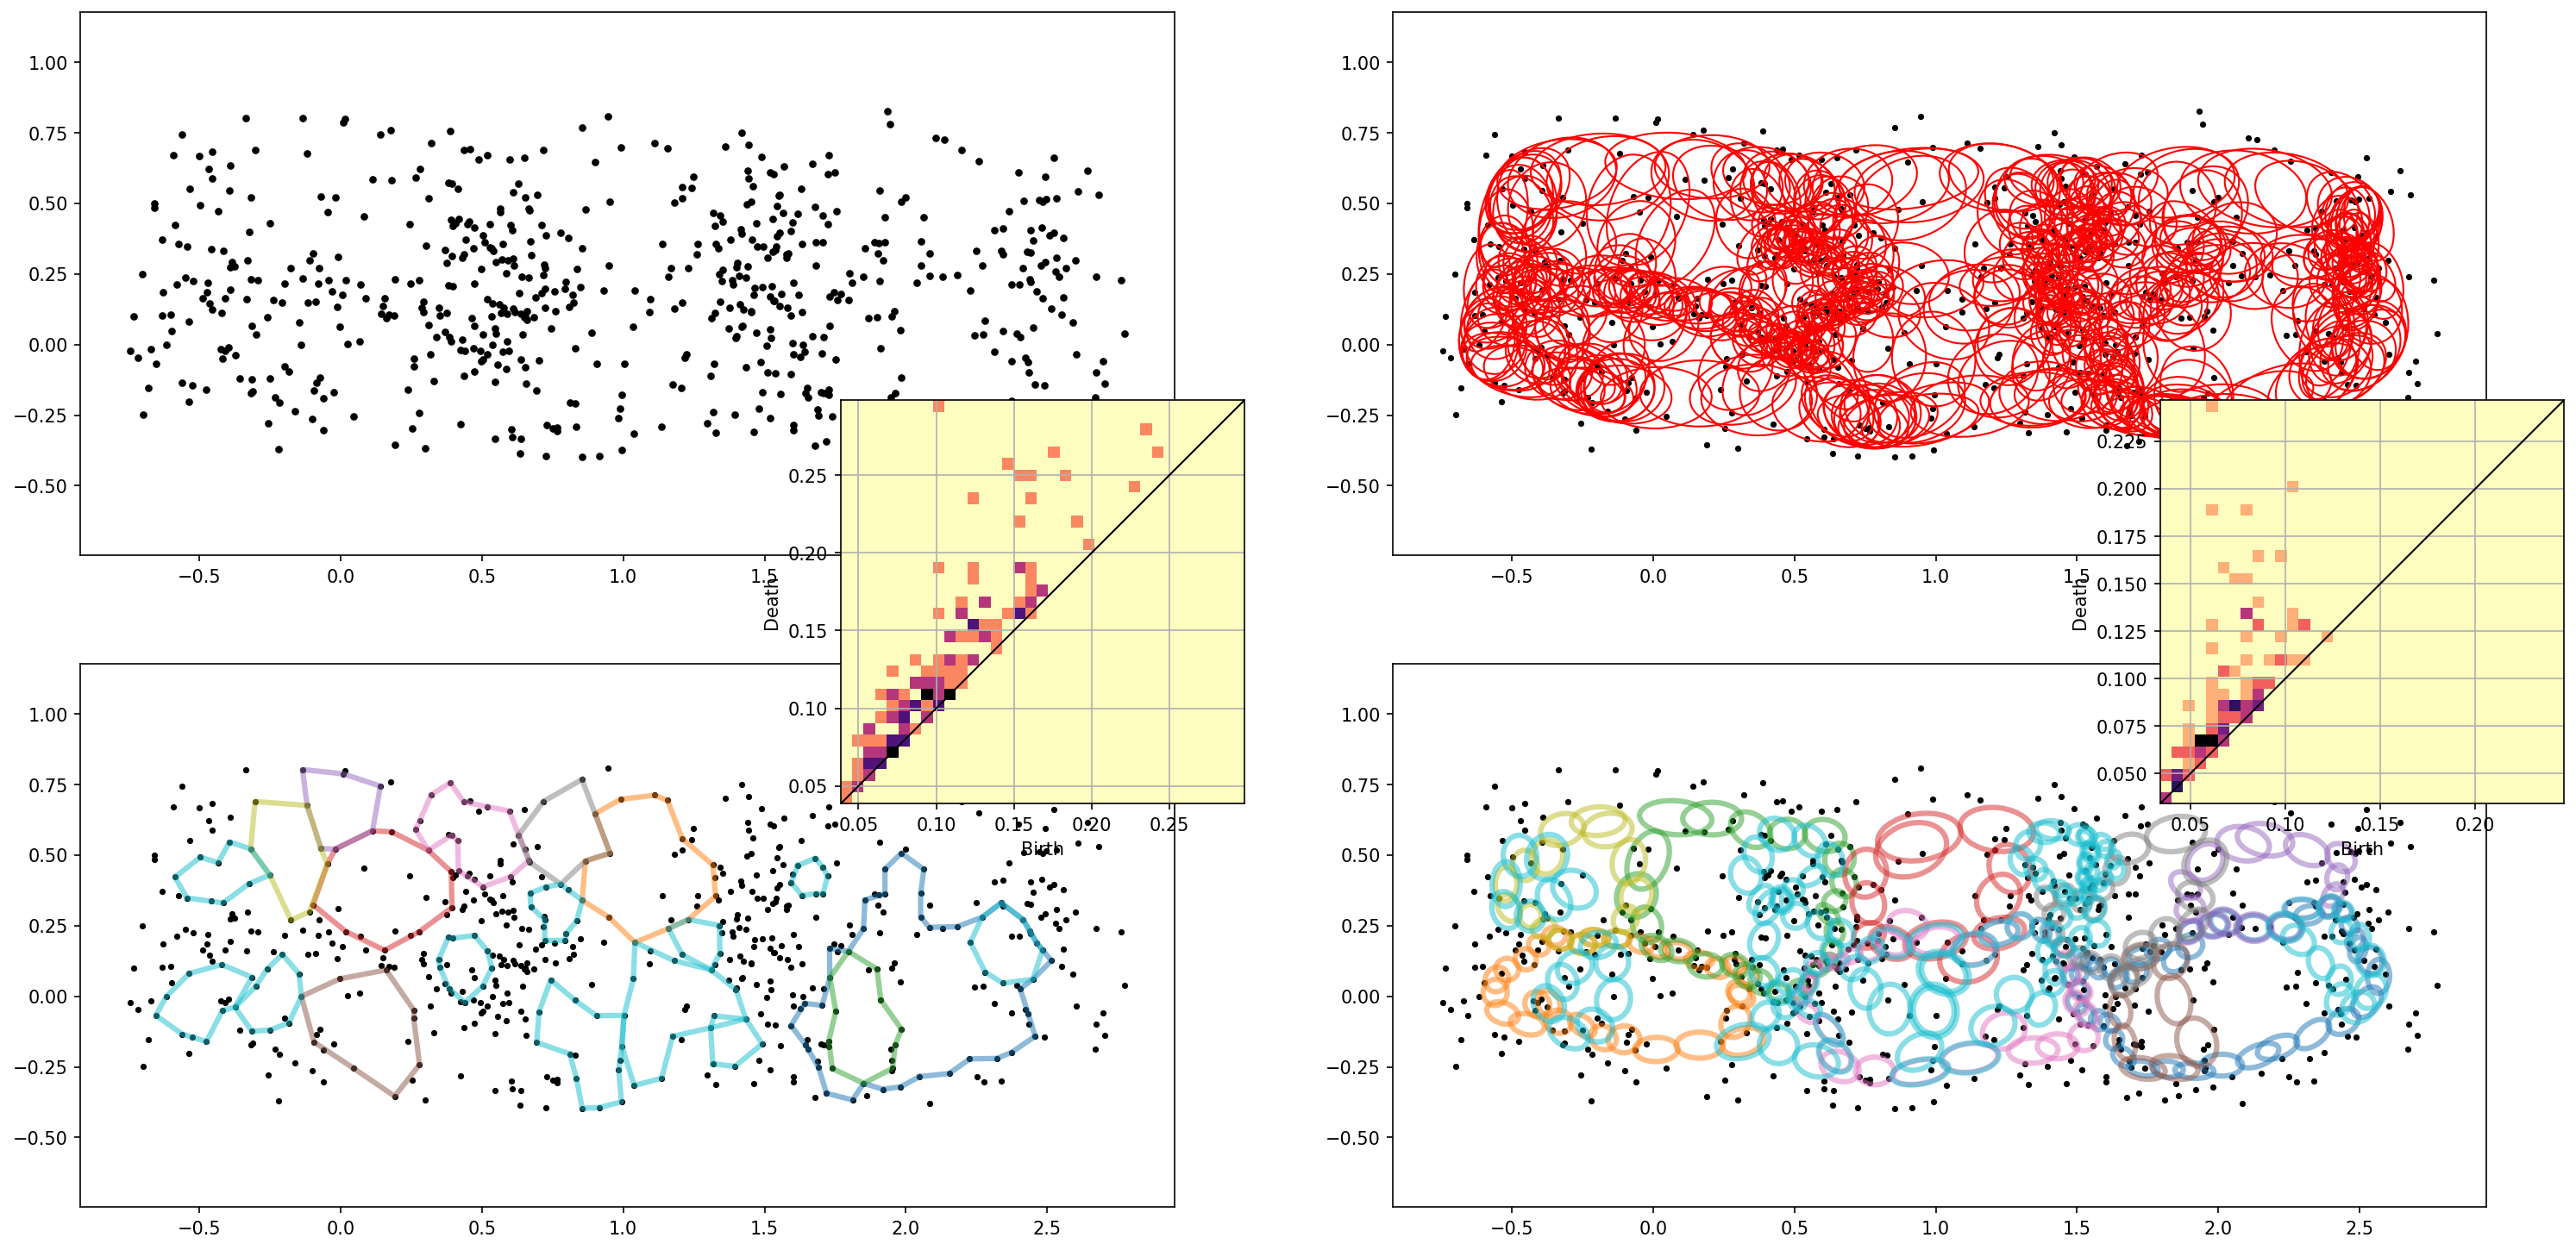

eps=0.25


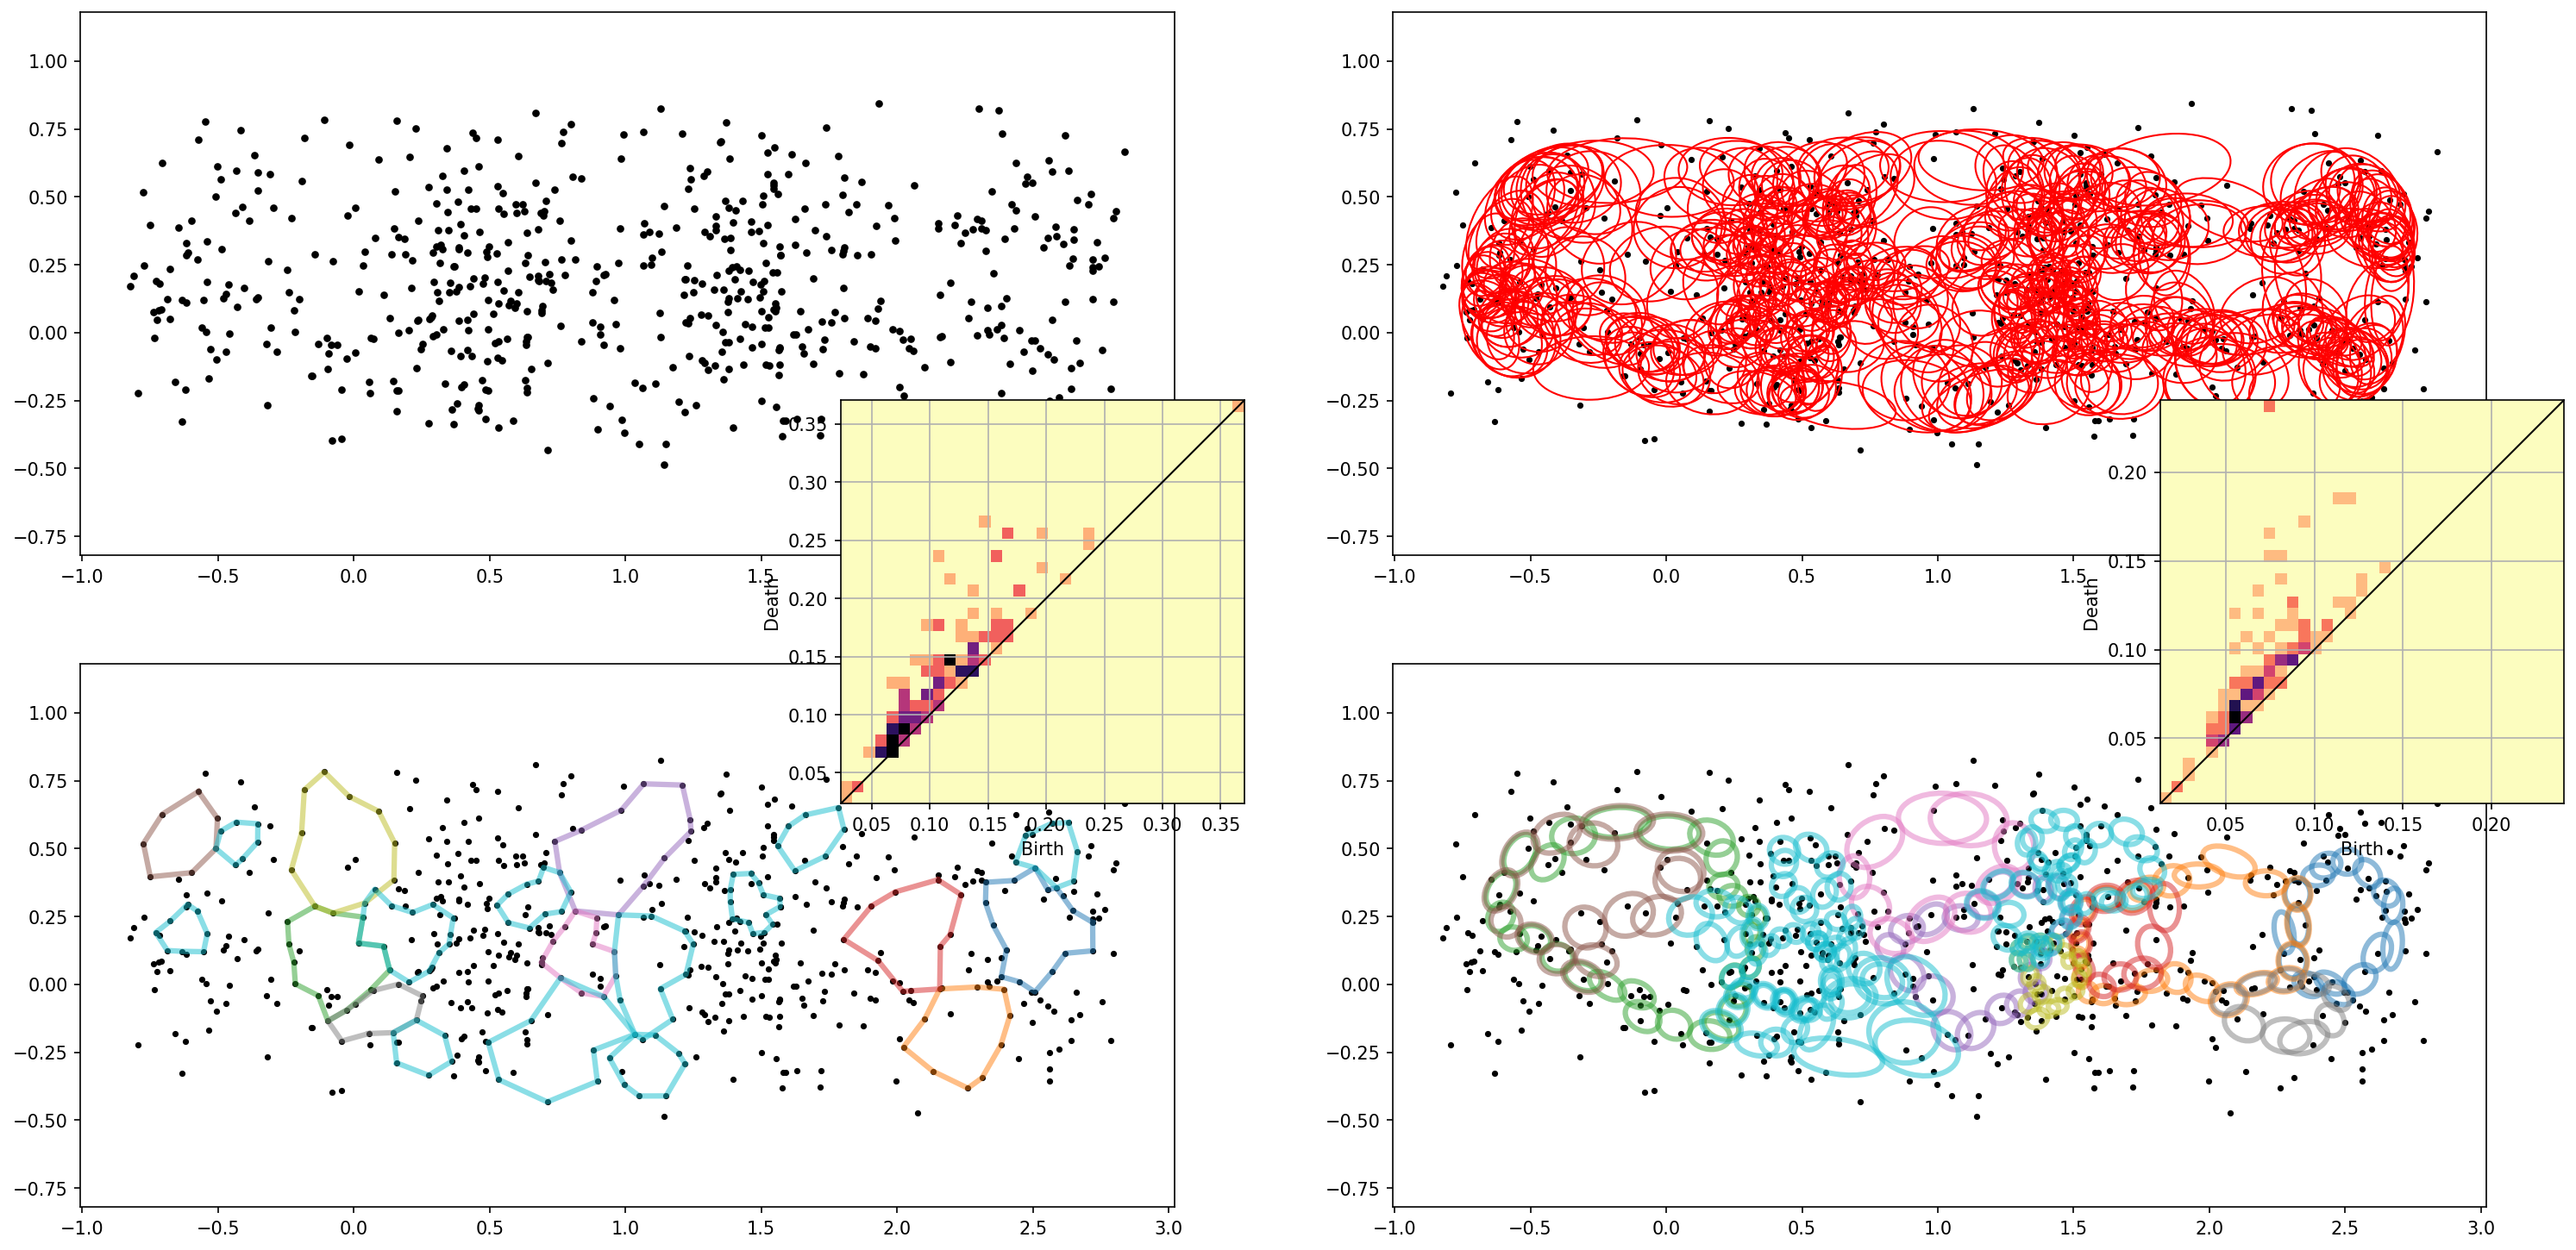

eps=0.2


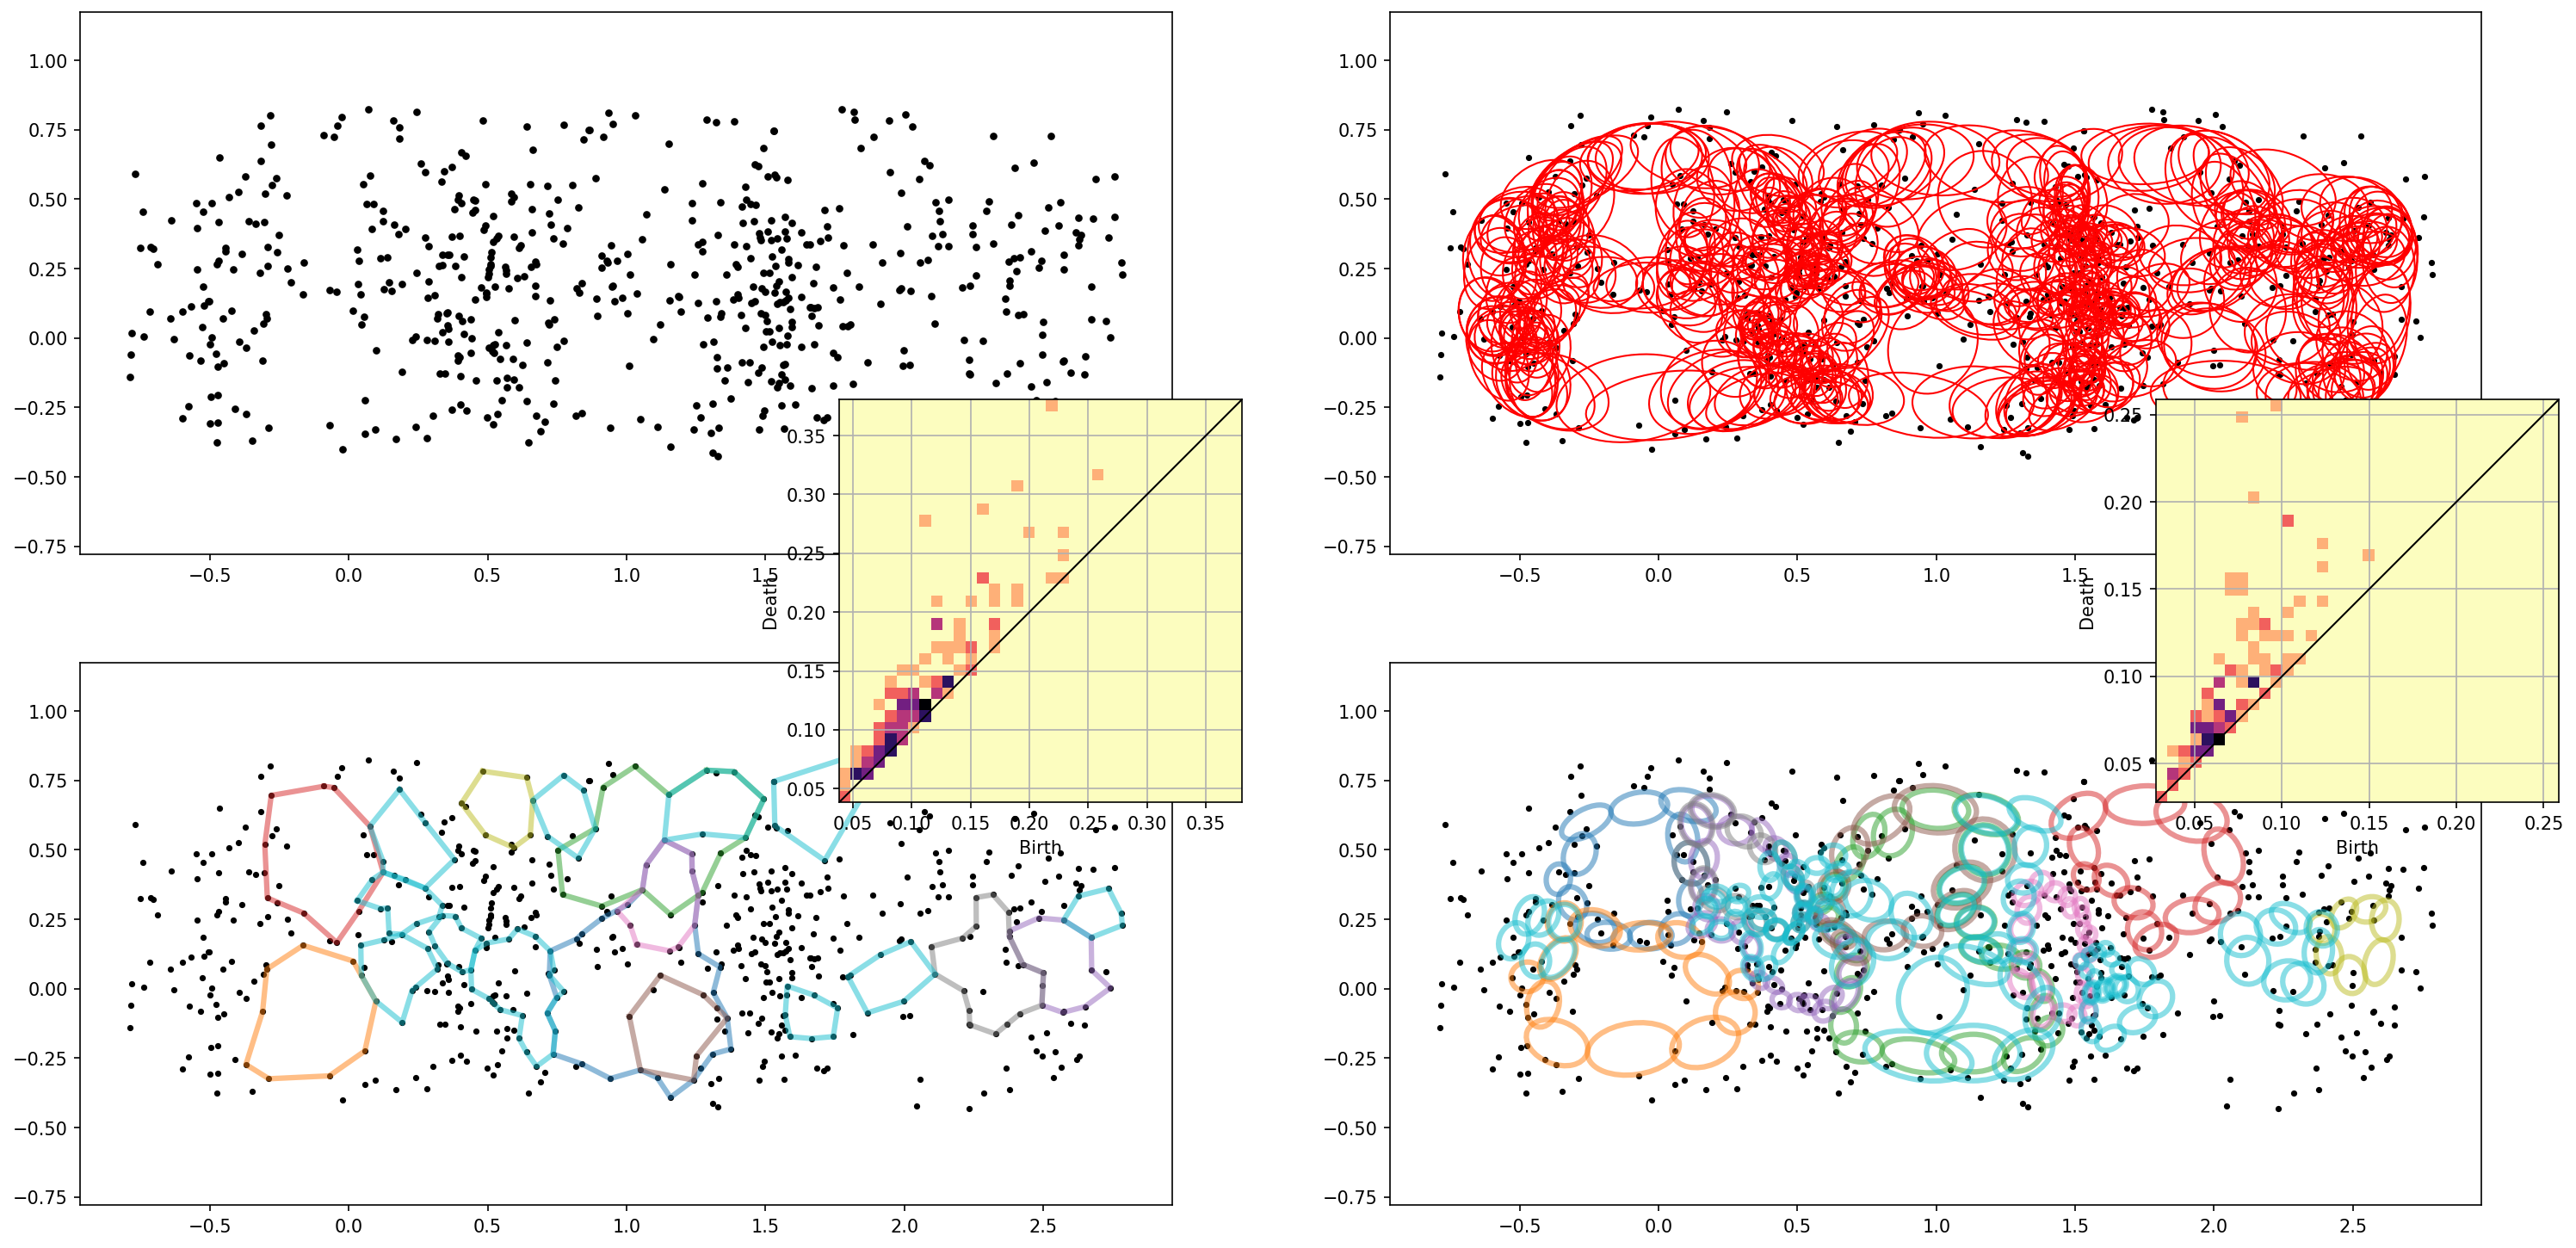

eps=0.15


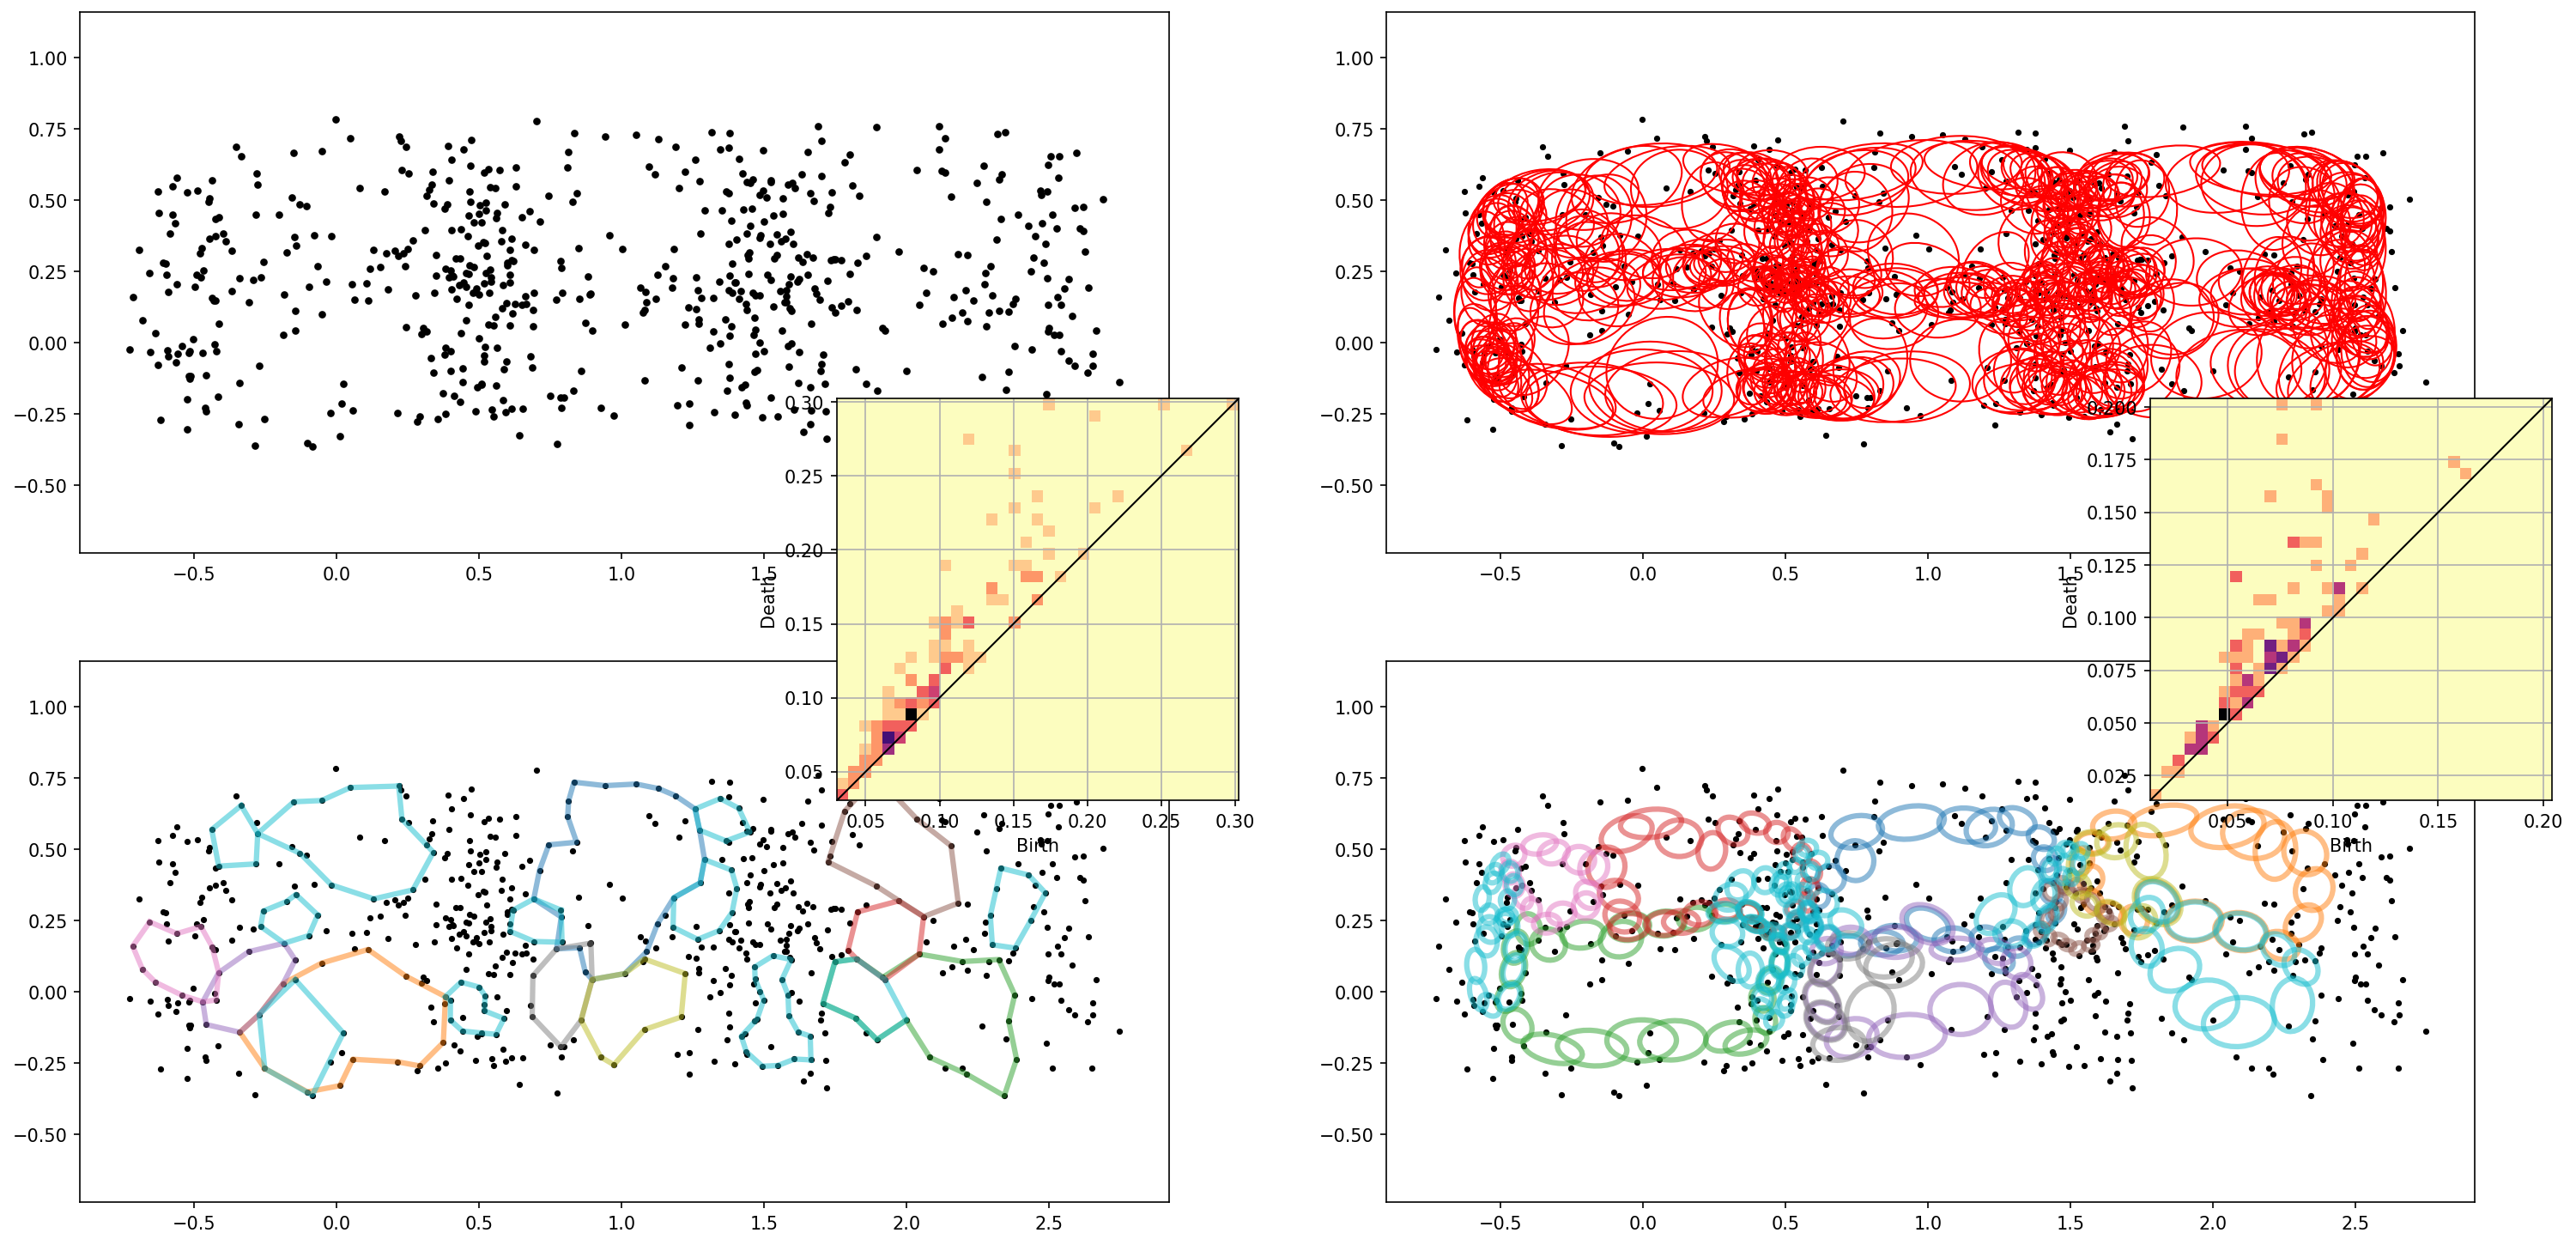

In [7]:
rng = numpy.random.default_rng(seed=7777) # 20250224
num_points = 100 # 基本円の点数
near = 25
eps_list = [0.19, 0.25, 0.20, 0.15]

# テスト生成データを一度捨てる
rng.uniform(0, 2 * numpy.pi, num_points)
rng.uniform(-eps_list[0], eps_list[0], size=(2, num_points))

for eps in eps_list:
    print(f'{eps=}')
    x, y = generate_noisy_rings(rng, **(rings_config | dict(eps=eps)))
    data = numpy.stack([x, y], axis=1)
    ellcloud = ellphi.ellipse_cloud(data, rescaling='none', k=near)
    ellscale = ellcloud.rescale(method='average')
    dist_orig = squareform(pdist(data))
    tangency = squareform(ellcloud.pdist_tangency())

    fig, ax = plt.subplots(2, 2, **fig_config)
    ax[0, 0].scatter(x, y, **(scatter_config | dict(s=10)))
    ax[0, 0].set_aspect('equal', adjustable='datalim')
    ax[0, 1].scatter(x, y, **scatter_config)
    ax[0, 1].set_aspect('equal', adjustable='datalim')
    ax[1, 0].scatter(x, y, **scatter_config)
    ax[1, 0].set_aspect('equal', adjustable='datalim')
    ax[1, 1].scatter(x, y, **scatter_config)
    ax[1, 1].set_aspect('equal', adjustable='datalim')
    ellcloud.plot(ax=ax[0, 1], edgecolor='red', scale=ellscale)
    # for _, mean, cov in ellipses:
    #     # p = ellipse_patch(*mean, cov=cov, scale=ell_scale)
    #     p.set(edgecolor='red', **ellipse_config)
    #     ax[0, 1].add_patch(p)
    
    subax1 = fig.add_axes([0.310, 0.37, 0.26, 0.26], facecolor='white')
    # subax1.set_axis_off()
    hc.PDList.from_rips_filtration(dist_orig, maxdim=1, save_to=pdgm_tmpfile, save_graph=True)
    pdlist = hc.PDList(pdgm_tmpfile)
    pd1 = pdlist.dth_diagram(1)
    pd1.histogram(x_bins=bins).plot(ax=subax1, **pd_hist_config)
    fig.axes[-1].remove() # remove colorbar
    
    take = 20
    sorted_pairs = sorted(
        pd1.pairs(), reverse=True,
        key=lambda p: p.death_time() - p.birth_time())
    for bd, color in zip(sorted_pairs[:take], cmap(numpy.arange(take))):
        opt1_cycle = bd.optimal_1_cycle()
        opt1_cycle_indices = opt1_cycle.boundary_points()
        line_indices = [*opt1_cycle_indices, opt1_cycle_indices[0]]
        ax[1, 0].plot(x[line_indices], y[line_indices], c=color, **(ellipse_config | dict(lw=3)))

    subax2 = fig.add_axes([0.735, 0.370, 0.26, 0.26], facecolor='white')
    # subax2.set_axis_off()
    hc.PDList.from_rips_filtration(tangency, maxdim=1, save_to=pdgm_tmpfile, save_graph=True)
    pdlist = hc.PDList(pdgm_tmpfile)
    pd1 = pdlist.dth_diagram(1)
    pd1.histogram(x_bins=bins).plot(ax=subax2, **pd_hist_config)
    fig.axes[-1].remove() # remove colorbar

    sorted_pairs = sorted(
        pd1.pairs(), reverse=True,
        key=lambda p: p.death_time() - p.birth_time())
    for bd, color in zip(sorted_pairs[:take], cmap(numpy.arange(take))):
        opt1_cycle = bd.optimal_1_cycle()
        ellcloud.plot(
            ids=opt1_cycle.boundary_points(),
            ax=ax[1, 1], edgecolor=color,
            scale=bd.birth_time(),
            **(ellipse_config | dict(lw=3))
        )
        # for bd_idx in opt1_cycle.boundary_points():
        #     e, mean, cov = ellipses[bd_idx]
        #     p = ellipse_patch(*mean, cov=cov, scale=bd.birth_time())
        #     p.set(edgecolor=color, **(ellipse_config | dict(lw=3)))
        #     ax[1, 1].add_patch(p)

    show_savefig(fig, f'comparison-eps{eps:1.3f}', show=True)

In [8]:
from tqdm import tqdm

In [9]:
rng = numpy.random.default_rng(seed=777) # 20250305

num_points = 50 # 基本円の点数
near = 10
num_stat_iter = 1000
eps = 0.19

nbins = 128

x_ranges = [(0, 0.5) for _ in experiments]
histospecs = [hc.HistoSpec(x_range=x_range, xbins=nbins) for x_range in x_ranges]
histos = [numpy.zeros((nbins, nbins), dtype='float64') for _ in experiments]

for _ in tqdm(range(num_stat_iter)):
    x, y = generate_noisy_rings(rng, **(rings_config | dict(num_points=num_points, eps=eps)))
    data = numpy.stack([x, y], axis=1)
    ellcloud = ellphi.ellipse_cloud(data, rescaling='none', k=near)
    ellscale = ellcloud.rescale(method='average')
    dist_orig = squareform(pdist(data))
    tangency = squareform(ellcloud.pdist_tangency())
    preprocessed_dist = squareform(pdist(ellcloud.mean))

    for i, d in enumerate((dist_orig, tangency, preprocessed_dist)):
        hc.PDList.from_rips_filtration(d, maxdim=1, save_to=pdgm_tmpfile, save_graph=True)
        pdlist = hc.PDList(pdgm_tmpfile)
        pd = pdlist.dth_diagram(1)
        histos[i] += histospecs[i].pd_histogram(pd).values

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [8:03:20<00:00, 29.00s/it]


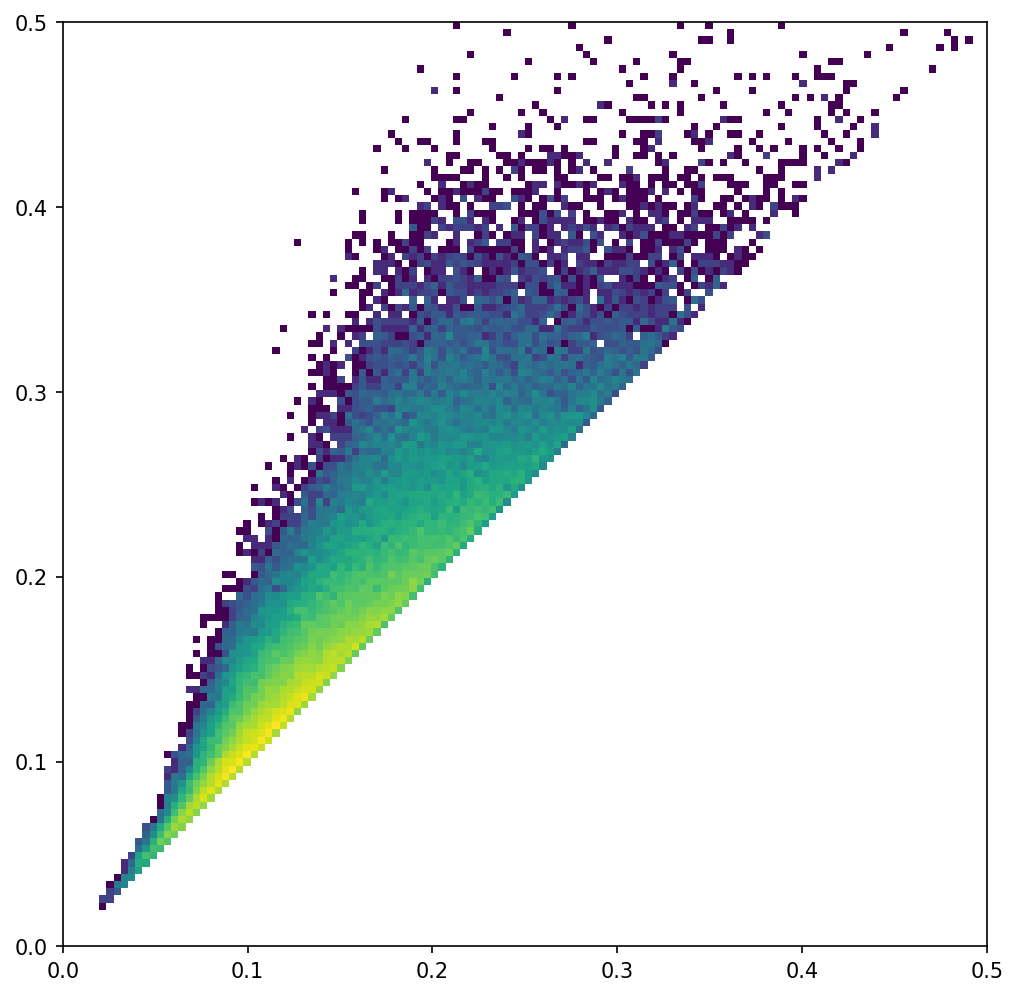

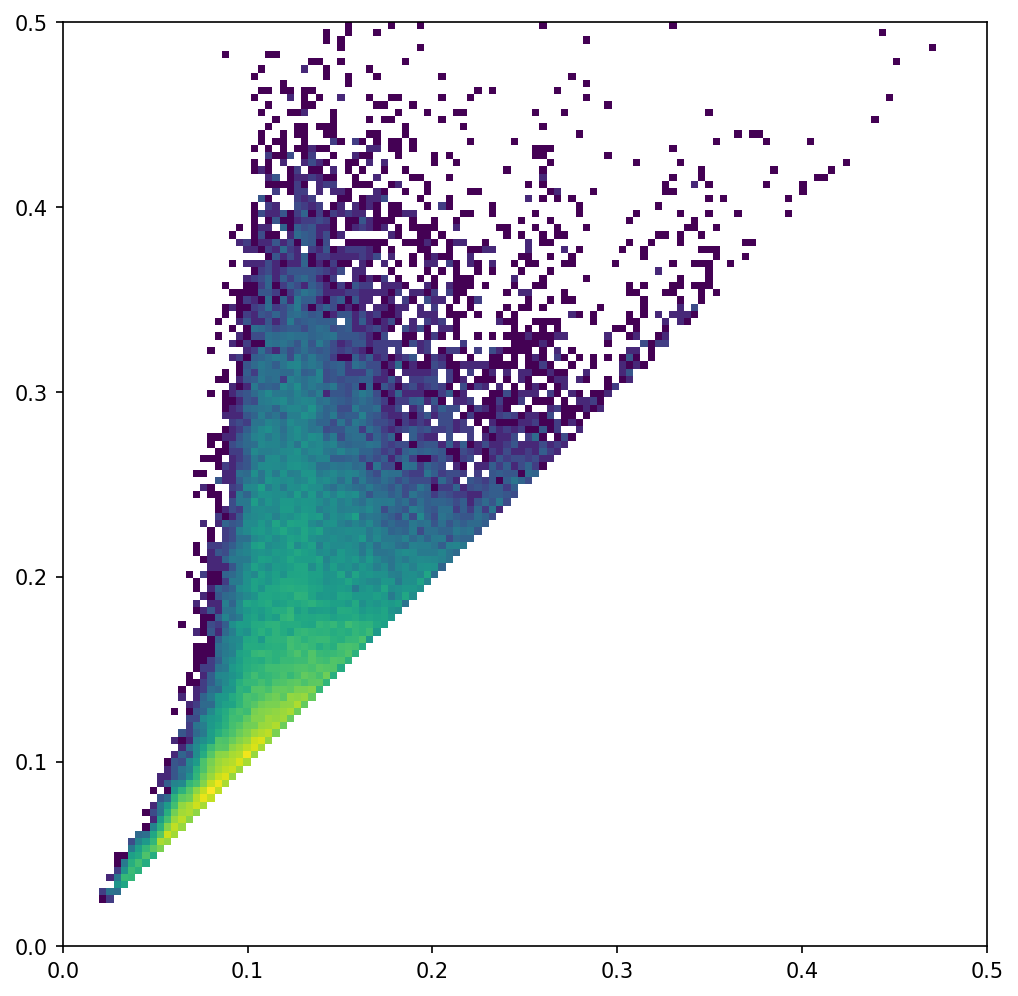

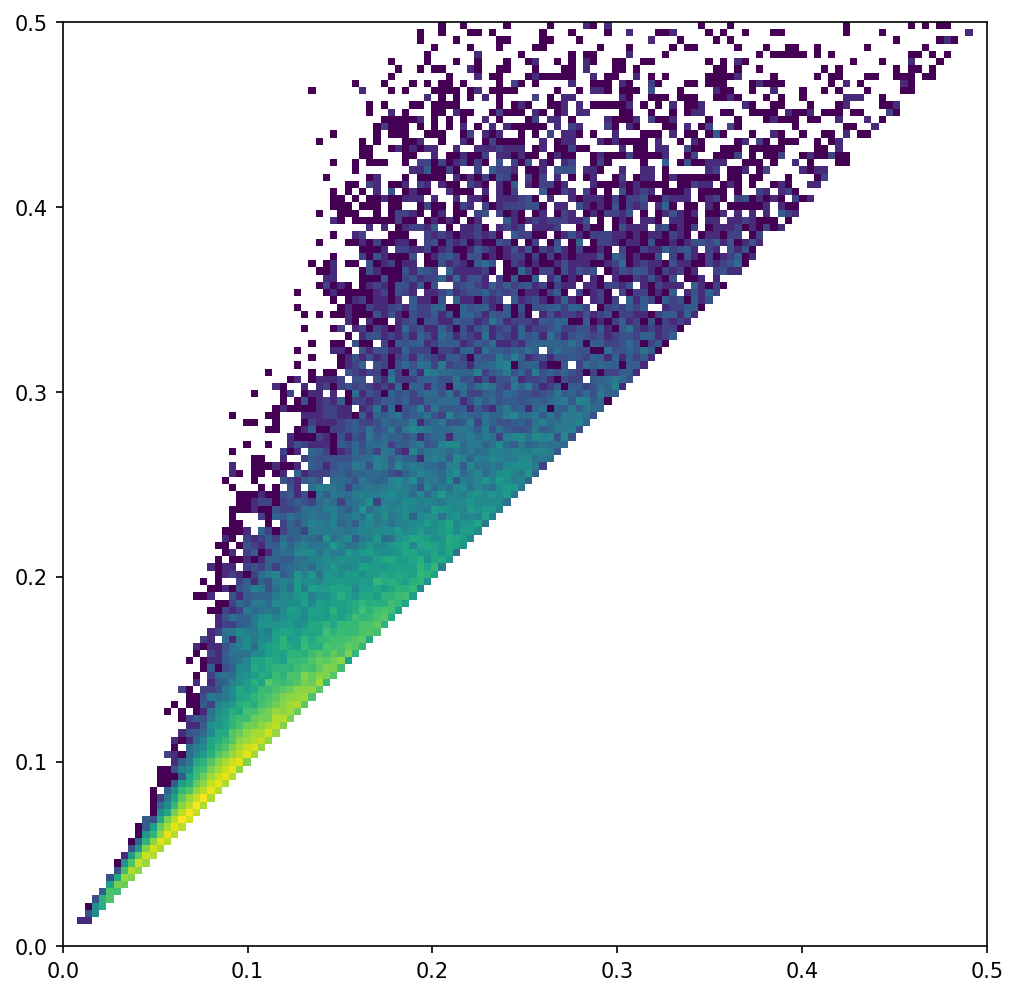

In [10]:
for i in range(len(experiments)):
    fig = plt.figure(figsize=(24, 8), dpi=150)
    plt.imshow(histos[i], extent=[*x_ranges[i], *x_ranges[i]], **imshow_config)
    show_savefig(fig, f'{experiments[i]}-PD-histo1k', show=True)

In [11]:
idx = numpy.arange(nbins - 1)
vmax = numpy.mean([numpy.percentile(histo[idx + 1, idx], 99)
                   for histo in histos])
vmax = numpy.around(vmax, decimals=-2)
vmax

np.float64(300.0)

In [12]:
int_log10_vmax = numpy.floor(numpy.log10(vmax)).astype('int')
cticks = [*numpy.logspace(0, int_log10_vmax, int_log10_vmax + 1), vmax]
clabels = [f'{tick:2.0f}' for tick in cticks]
clabels[-1] = "≧" + clabels[-1]
clabels

[' 1', '10', '100', '≧300']

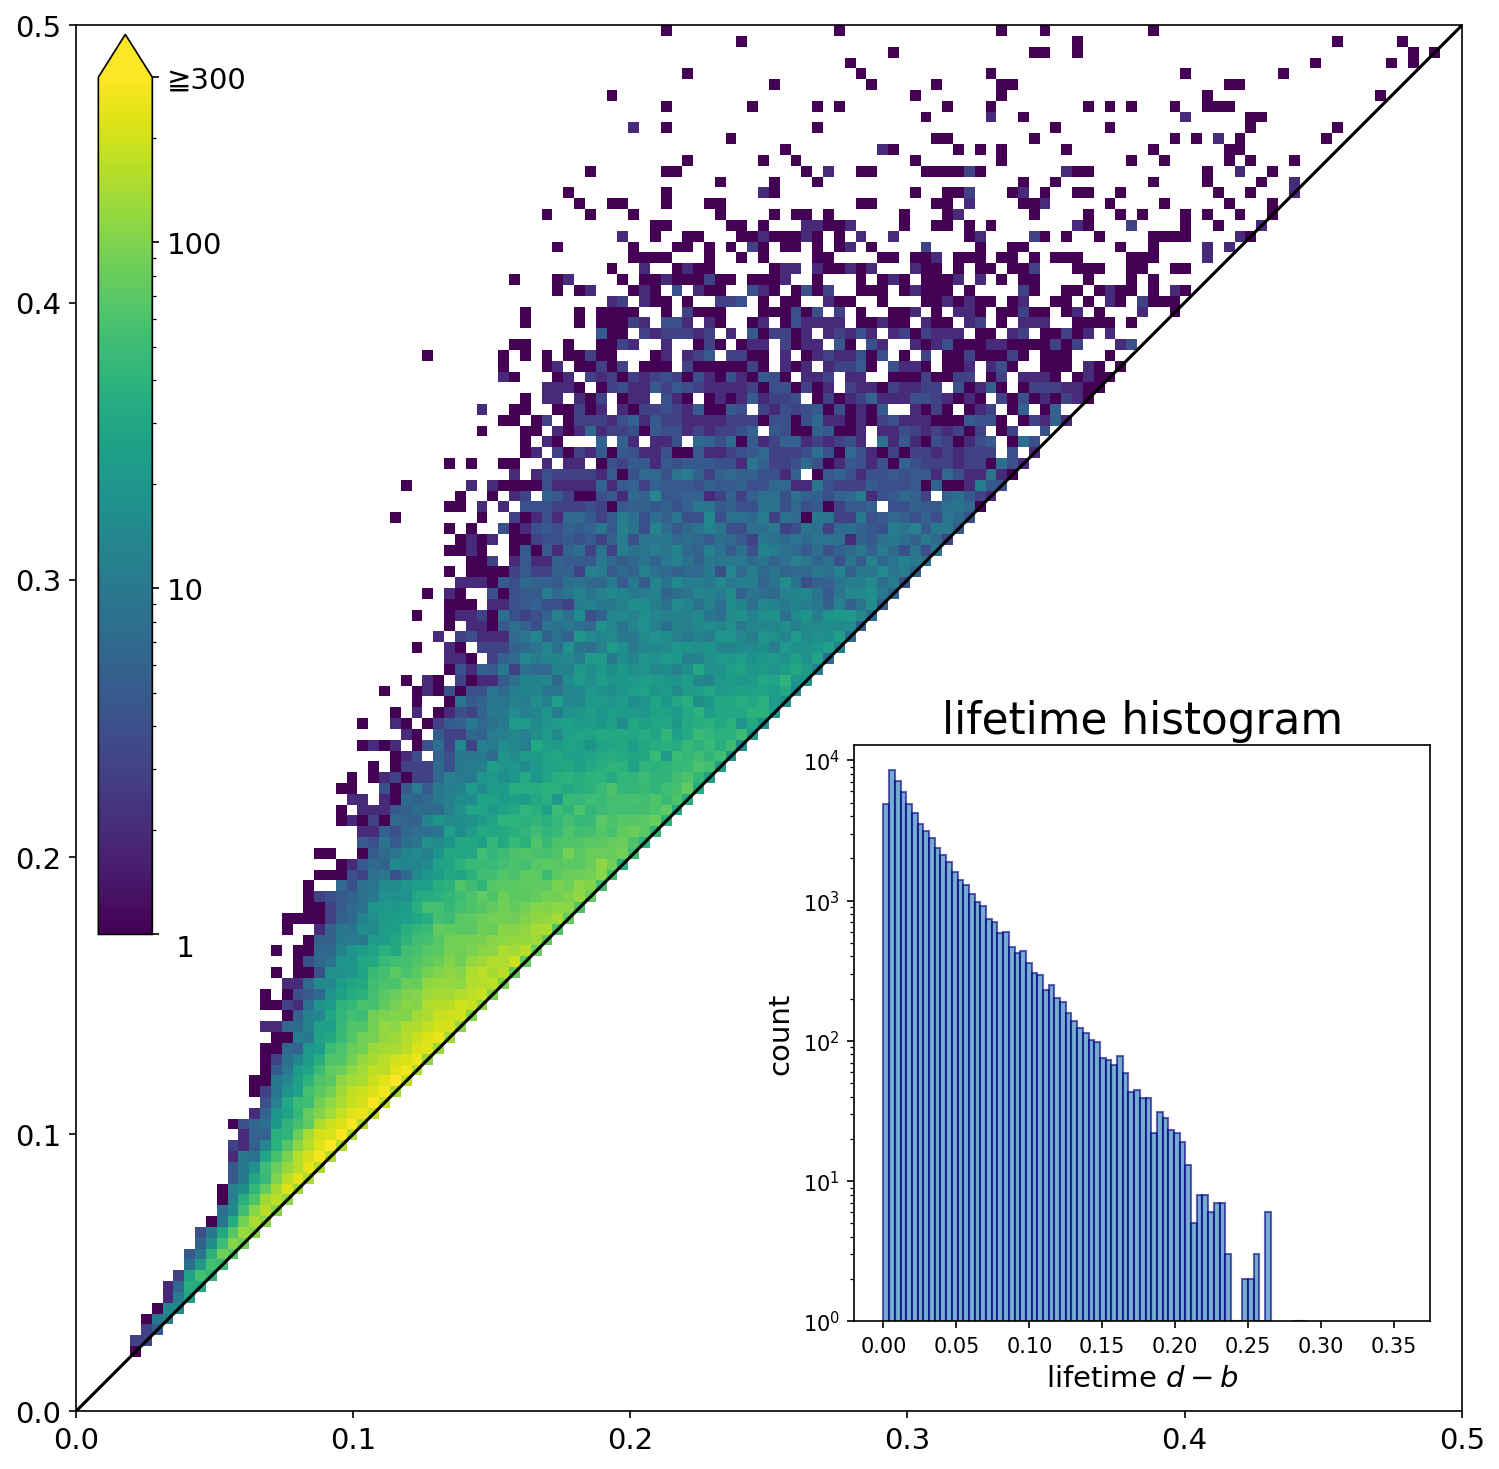

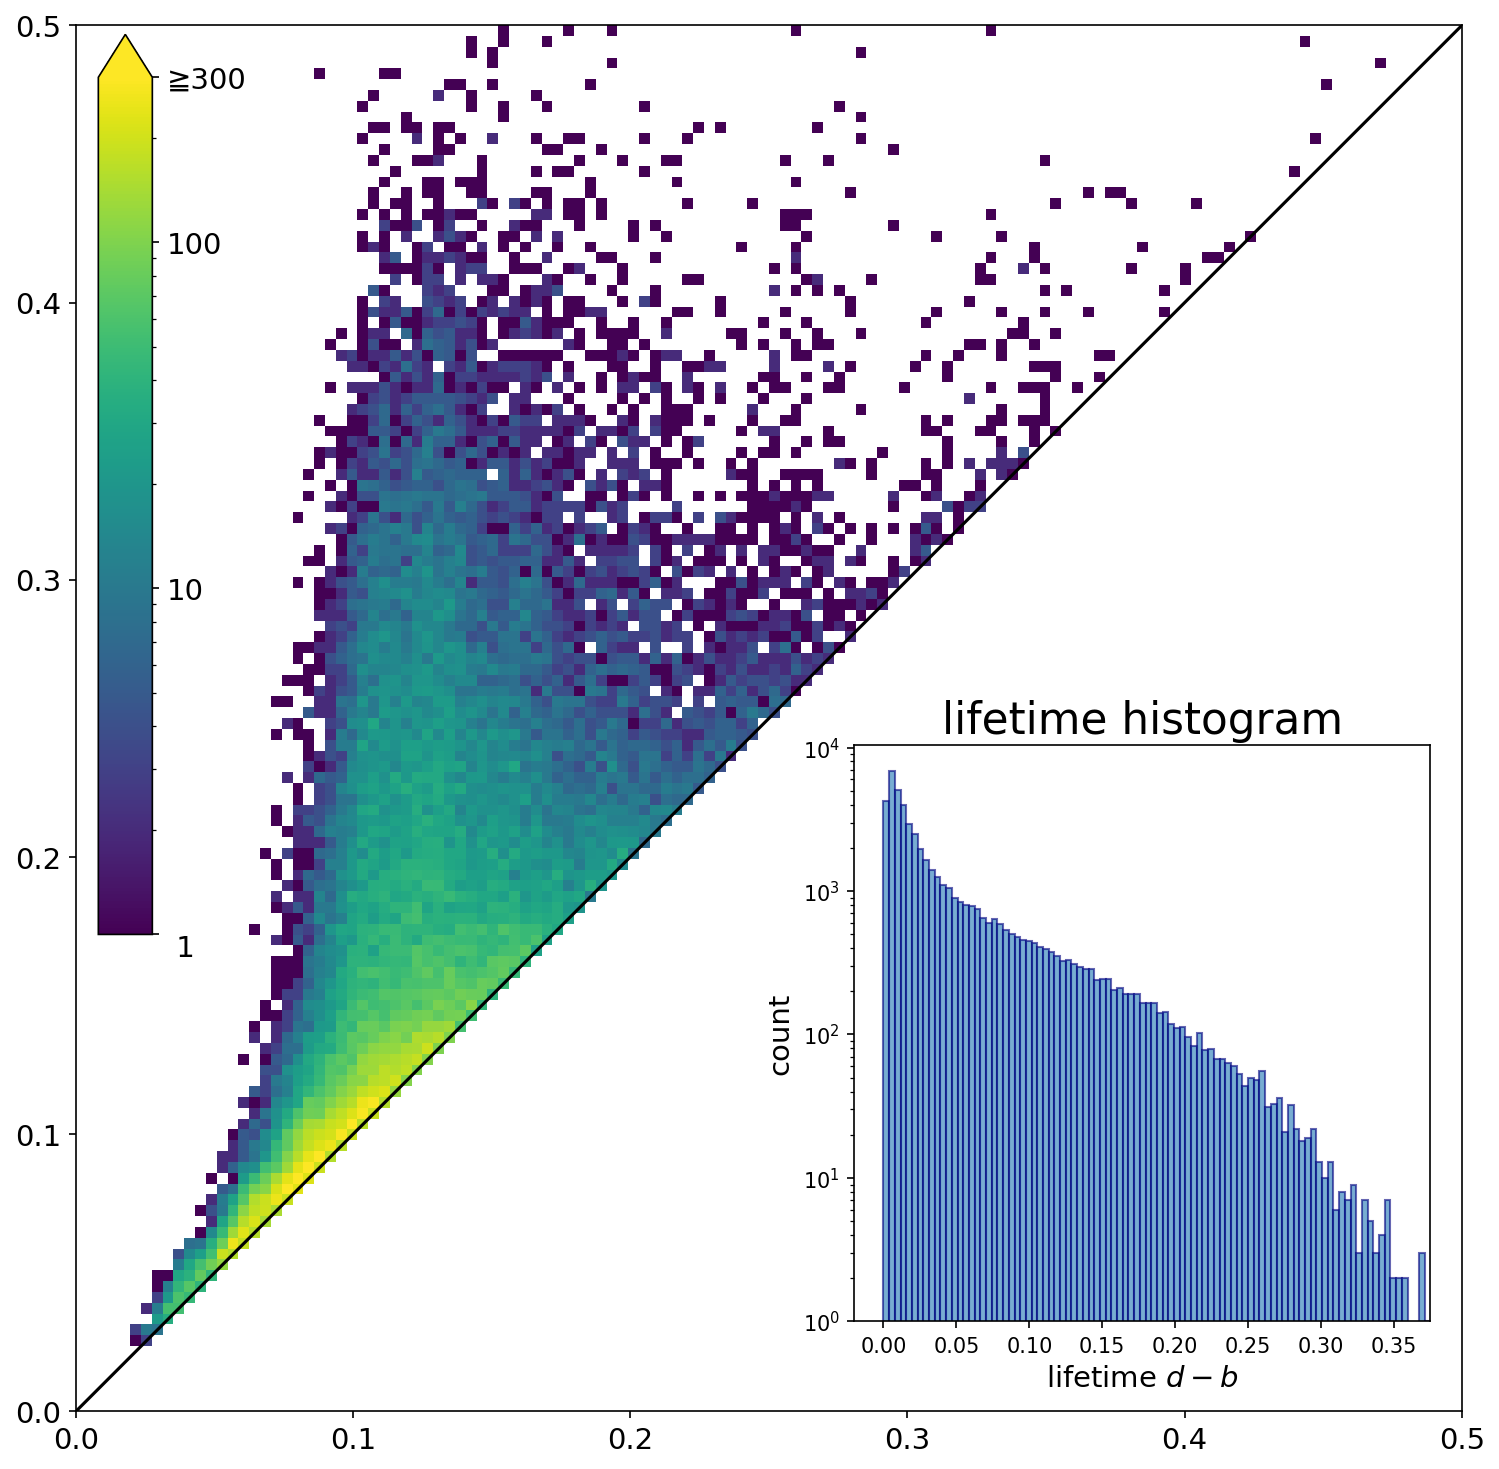

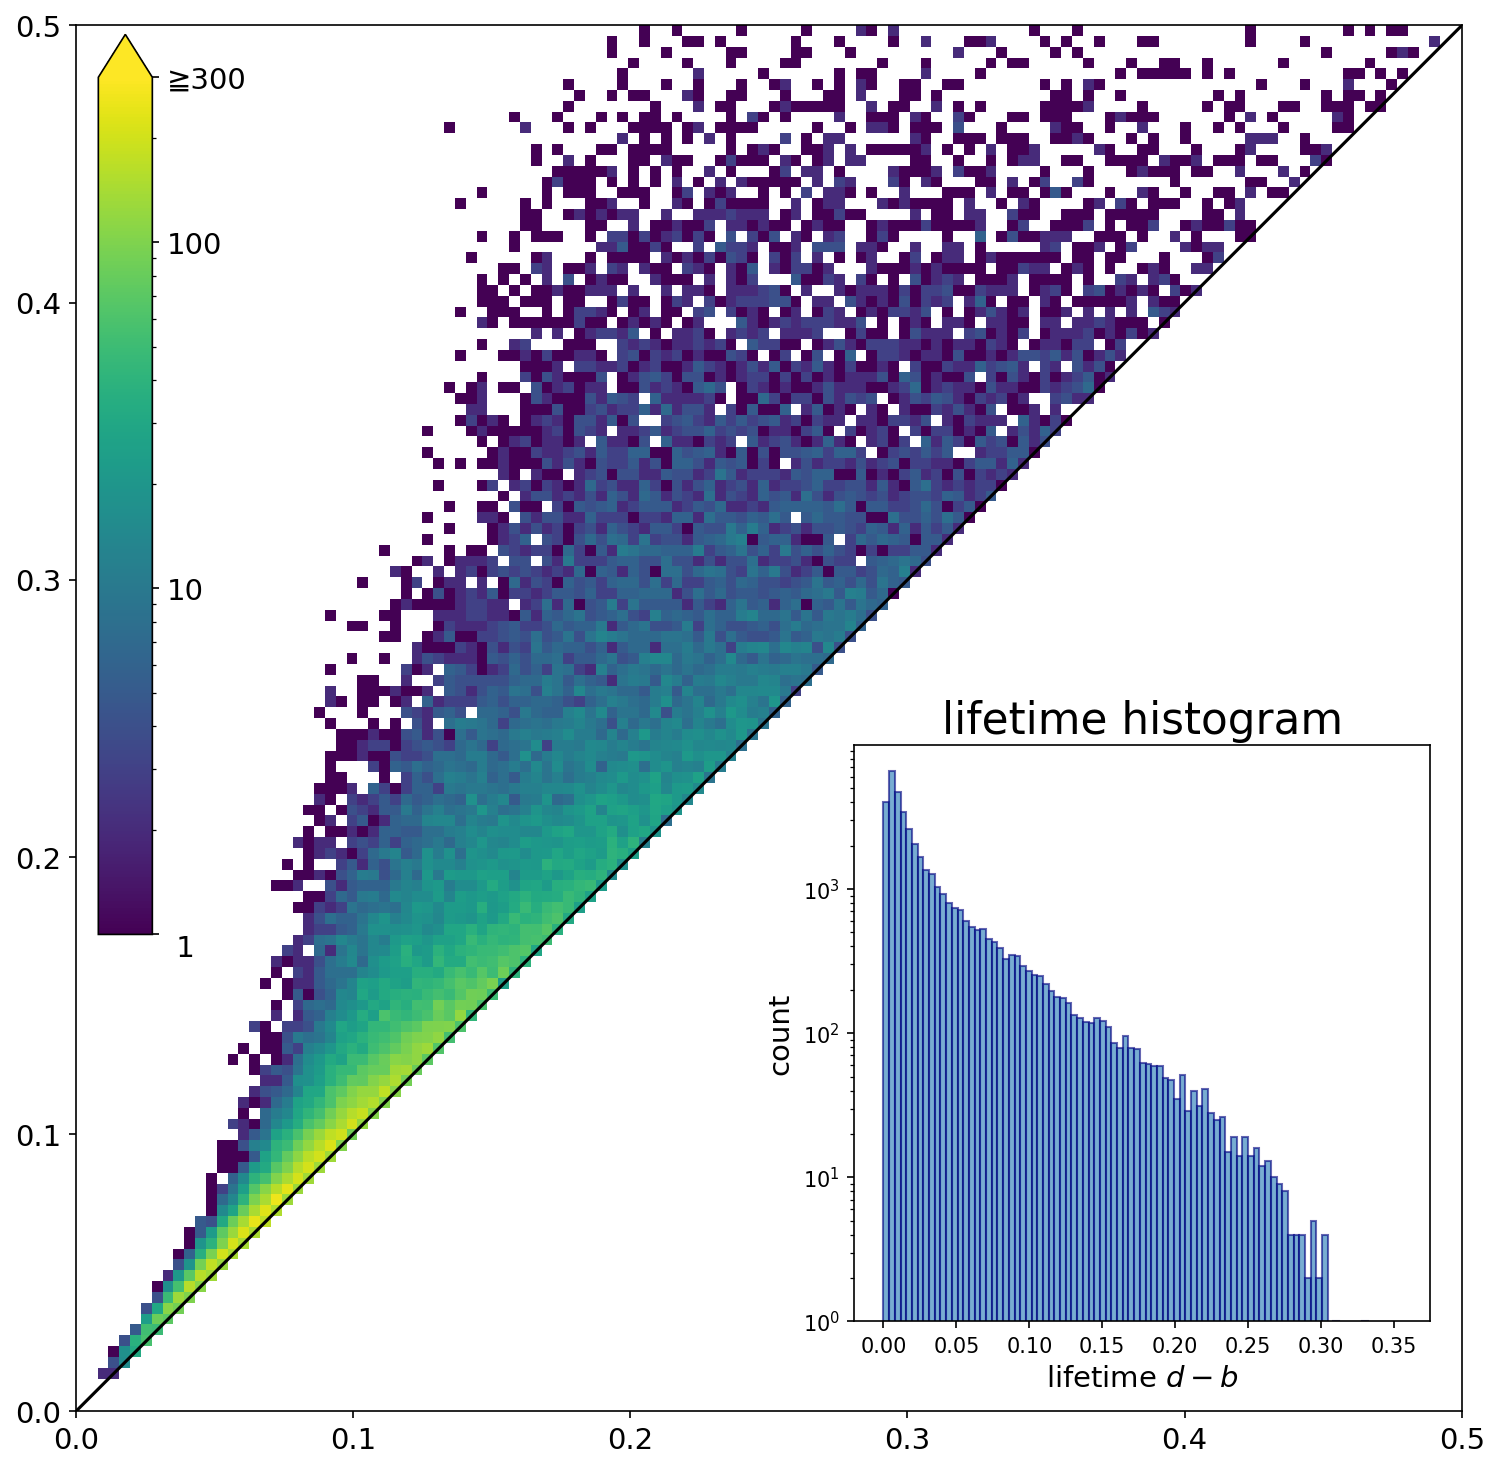

In [13]:
import matplotlib.ticker as mticker

fontsize = 14

for i in range(len(experiments)):
    fig = plt.figure(**(fig_config | dict(figsize=(12, 12))))
    im = plt.imshow(histos[i], vmax=vmax, extent=[*x_ranges[i], *x_ranges[i]], **imshow_config)
    im.axes.plot(x_ranges[i], x_ranges[i], color='k')
    im.axes.tick_params(labelsize=fontsize)

    cax = fig.add_axes([0.14, 0.375, 0.03, 0.5])
    cbar = plt.colorbar(im, cax=cax,
                        ticks=cticks,
                        format=mticker.FixedFormatter(clabels),
                        extend='max')
    cax.tick_params(labelsize=fontsize)
    labels = cbar.ax.get_yticklabels()
    labels[0].set_verticalalignment('top')

    idx = numpy.arange(nbins)
    b, d = numpy.meshgrid(idx, idx, indexing='xy')
    x = idx / nbins * x_ranges[i][1]
    bins = [numpy.sum(histos[i][(d - b) == life]) for life in idx]

    subax = fig.add_axes([0.56, 0.16, 0.32, 0.32], facecolor='white')
    hp = subax.hist(x[:-1], x, weights=bins[:-1], log=True, alpha=0.6, ec='navy')
    y_max = int(max(hp[0])) * 1.5
    subax.set_xlim([-0.02, x_ranges[i][1]*0.75])
    subax.set_ylim([1, y_max])
    subax.set_xlabel('lifetime $d - b$', fontsize=fontsize)
    subax.set_ylabel('count', fontsize=fontsize)
    subax.set_title('lifetime histogram', fontsize=fontsize*1.5)
    
    show_savefig(fig, f'{experiments[i]}-PD-histo1k', show=True, bbox_inches='tight')

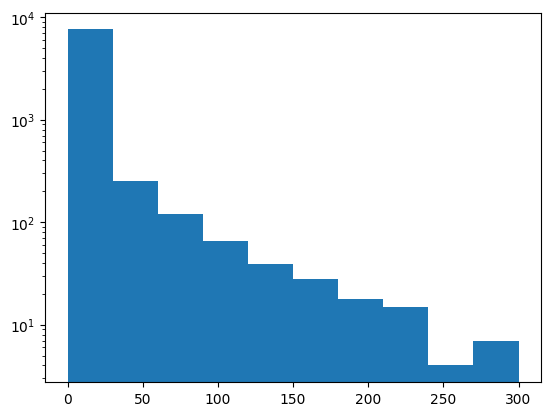

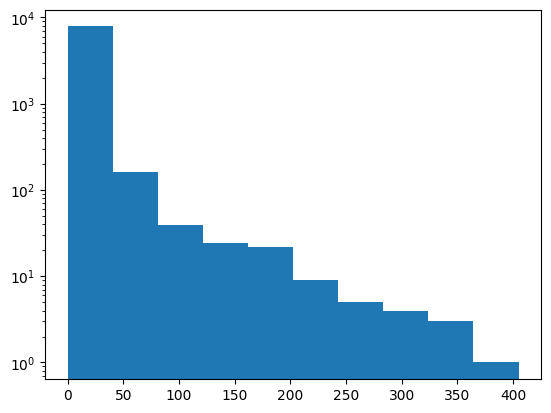

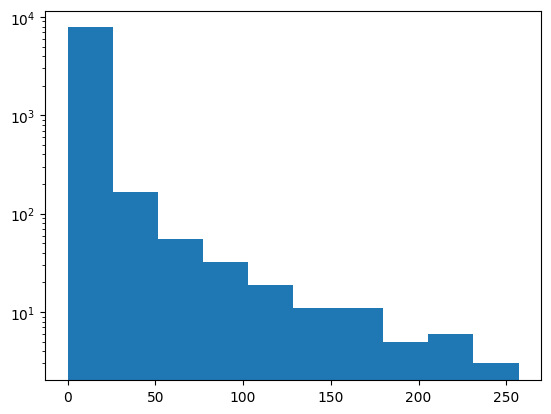

In [14]:
idx = numpy.arange(nbins)
b, d = numpy.meshgrid(idx, idx, indexing='xy')

for histo in histos:
    plt.hist(histo[(d - b) > 0.0], log=True)
    plt.show()